# Image Classification Using Pytorch Libraries
In this project I implement basic image classification techniques using a pneumonia dataset that contains images for binary classification of normal and pneumonia classes.
<br>
The input for the model is a chest-xray image and the output is the prediction with confidence for normal and pneumonia classes.
<br>
The project flows in sequential order and the exectution of each cell gives an idea of the basic techniques and workflow of a typical machine learning application project.

Dataset downloaded from: [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)


Instructions to download dataset into google colab environment can be found, [here](https://saturncloud.io/blog/how-to-use-kaggle-datasets-in-google-colab/)


In [ ]:
!pip install kaggle

In [ ]:
! mkdir -p /root/.kaggle/
!mv -u kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
! unzip chest-xray-pneumonia.zip

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

# These are the helper functions

def show_image(image,label,get_denormalize = True):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)

    else:
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image*std + mean
    image = np.clip(image,0,1)

    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):

    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])


    image = image*std + mean
    img = np.clip(image,0,1)

    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
class classifierConfig:
  epochs = 20
  lr = 0.001
  batch_size = 16

  model_name = 'tf_efficientnet_b4_ns'
  img_size = 224

  DATA_DIR = 'chest_xray'
  TEST = 'test'
  TRAIN = 'train'
  VAL = 'val'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Current Device: {}".format(device))

Current Device: cuda


In [ ]:
from torchvision import transforms as T, datasets

In [ ]:
# pre processing the images by applying image transforms

train_transform = T.Compose([
    T.Resize(size = (classifierConfig.img_size, classifierConfig.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    T.Resize(size = (classifierConfig.img_size, classifierConfig.img_size)),
    # T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(size = (classifierConfig.img_size, classifierConfig.img_size)),
    # T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# loading the datasets for test, validation, and test sets

train_path = os.path.join(classifierConfig.DATA_DIR, classifierConfig.TRAIN)
valid_path = os.path.join(classifierConfig.DATA_DIR, classifierConfig.VAL)
test_path = os.path.join(classifierConfig.DATA_DIR, classifierConfig.TEST)

trainset = datasets.ImageFolder(train_path, transform= train_transform)
validset = datasets.ImageFolder(valid_path, transform= valid_transform)
testset = datasets.ImageFolder(test_path, transform= test_transform)


In [ ]:
# checking the number of examples in each set

print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


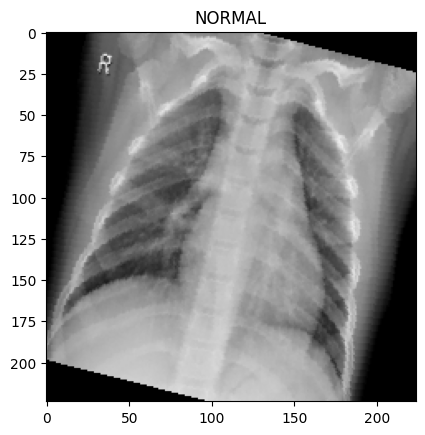

In [ ]:
image, label = trainset[5]

class_name = ['NORMAL', 'PNEUMONIA']

show_image(image, class_name[label]) # the image stored in the idx gets randomly rotated every time it is retrieved

In [ ]:
# use dataloader to load data into batches

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

trainloader = DataLoader(trainset, batch_size = classifierConfig.batch_size, shuffle= True)
validloader = DataLoader(validset, batch_size = classifierConfig.batch_size, shuffle= True)
testloader = DataLoader(testset, batch_size = classifierConfig.batch_size, shuffle= True)

In [ ]:
print("Number of bathces in the trainloader : {}".format(len(trainloader)))
print("Number of Total examples : {}".format(len(trainloader.dataset)))

Number of bathces in the trainloader : 326
Number of Total examples : 5216


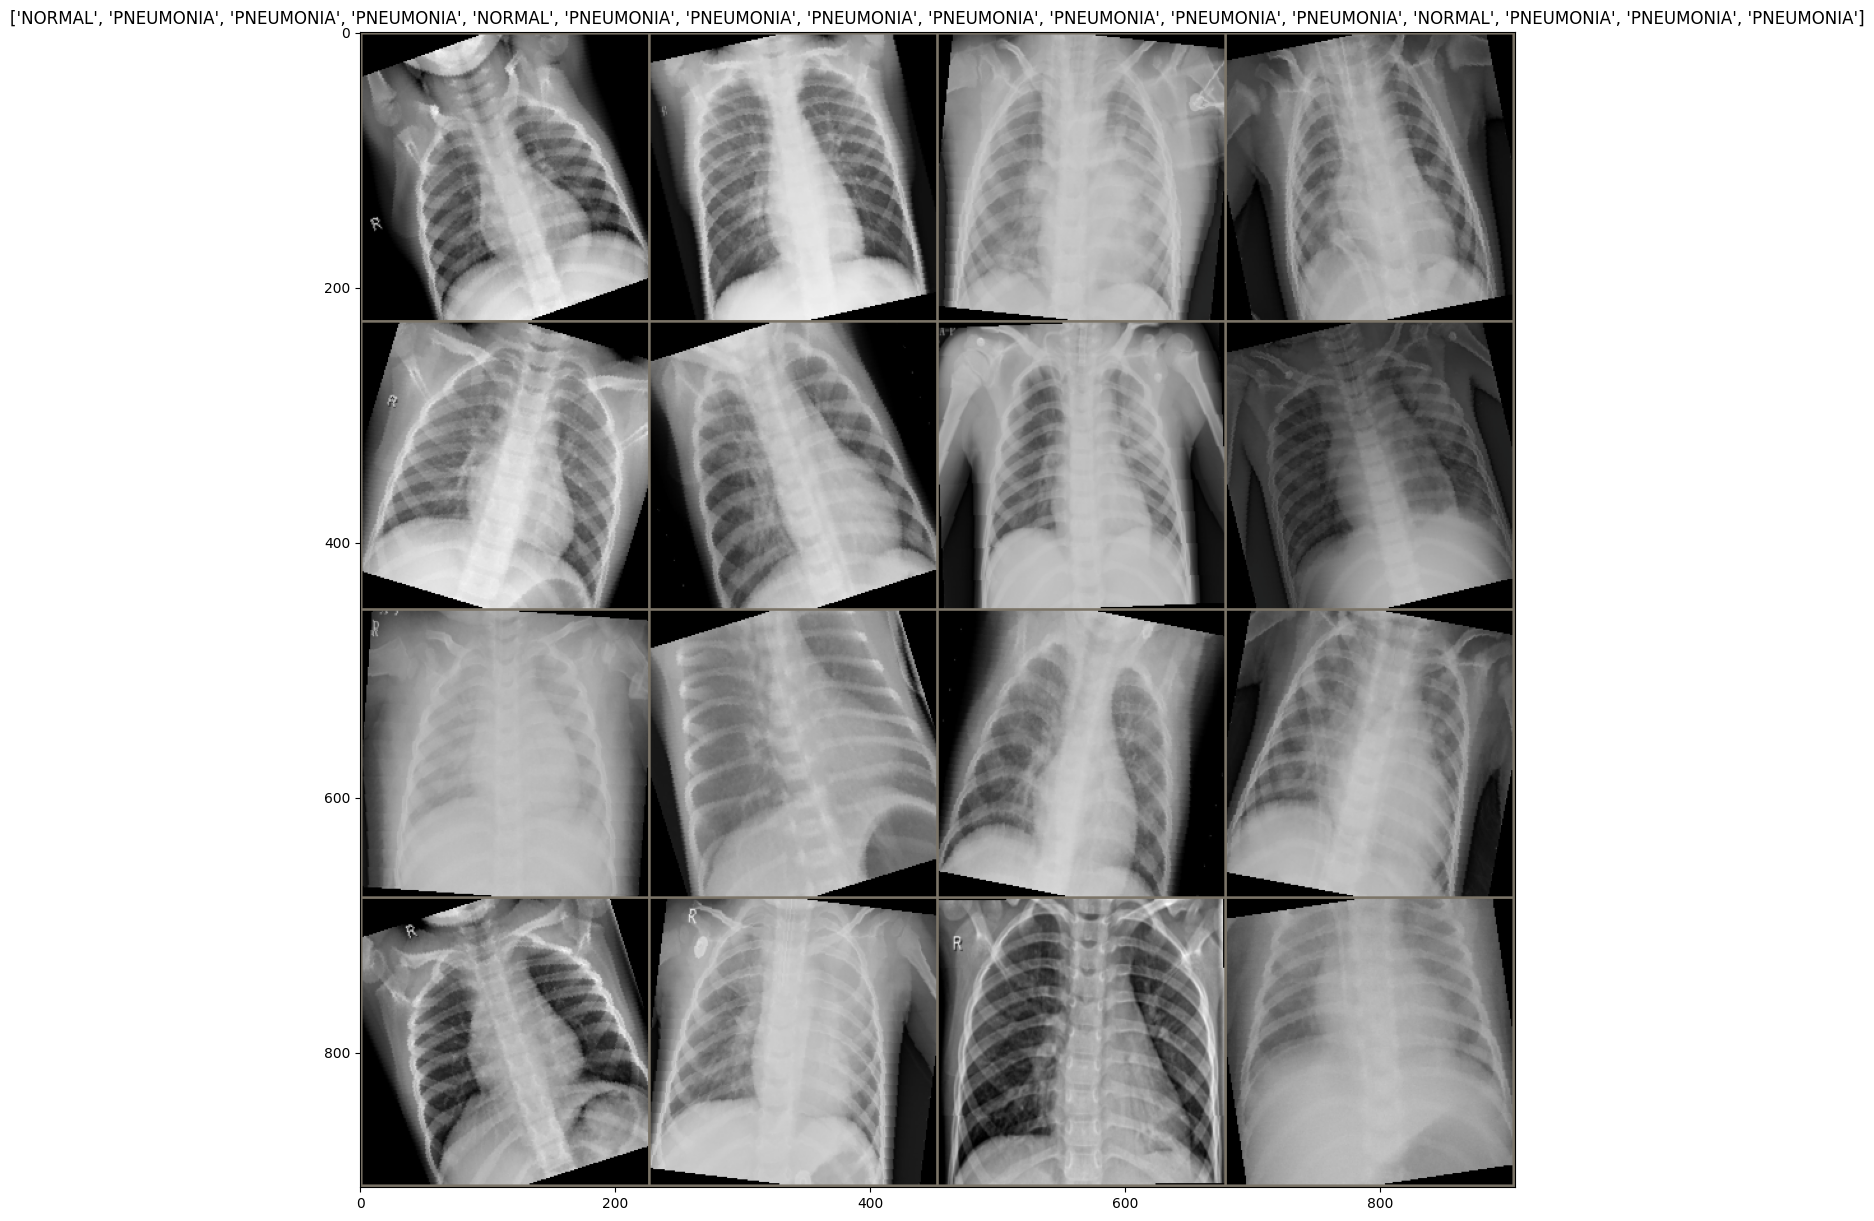

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
out = make_grid(images, nrow= 4)
show_grid(out,title = [class_name[x] for x in labels])

In [ ]:
! pip install timm

In [ ]:
# loading a pre trained model from pytorch

from torch import nn
import torch.nn.functional as F
import timm


In [ ]:
model = timm.create_model(classifierConfig.model_name, pretrained = True)

# Model is trained on imagenet which has 1000 classes so the output layer will have 1000 classes
# Modifying the final layer in include only two classes

# Freezing the model
for param in model.parameters():
  param.requires_grad = False

# Defining the final classifier layer
model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2)
)

model.to(device)

In [ ]:
! pip install torchinfo

In [ ]:
# Checking the summary of the model
import torchinfo

torchinfo.summary(model, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 1)

# trainable parameters are less because only weights in the sequential classifier will be updated and rest of them are frozen

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                  [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─Conv2dSame: 1-1                             [1, 3, 224, 224]          [1, 48, 112, 112]         (1,296)                   [3, 3]                    16,257,024
├─BatchNormAct2d: 1-2                         [1, 48, 112, 112]         [1, 48, 112, 112]         96                        --                        --
│    └─Identity: 2-1                          [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
│    └─SiLU: 2-2                              [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
├─Sequential: 1-3                             [1, 48, 112, 112]    

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                  [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─Conv2dSame: 1-1                             [1, 3, 224, 224]          [1, 48, 112, 112]         (1,296)                   [3, 3]                    16,257,024
├─BatchNormAct2d: 1-2                         [1, 48, 112, 112]         [1, 48, 112, 112]         96                        --                        --
│    └─Identity: 2-1                          [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
│    └─SiLU: 2-2                              [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
├─Sequential: 1-3                             [1, 48, 112, 112]    

In [ ]:
# building a trainer to train the classifier head

class classifierTrainer():
  # initializing the class attributes
  # criterion: computes the cross entropy loss between input logits and target
  # optimizer: adjusts the weights during training in order to get a minimum loss
  # scheduler: used to make learning rate adaptive to the gradient descent optimization procedure
  def __init__(self,criterion=None, optimizer=None, scheduler=None):
    self.criterion = criterion
    self.optimizer = optimizer
    self.scheduler = scheduler

  def train_batch_loop(self, model, trainloader):
    train_acc = 0.0
    train_loss = 0.0

    for images, labels in tqdm(trainloader):

      images = images.to(device)
      labels = labels.to(device)

      logits = model(images) # logits is raw output (without any softmax activation
      loss = self.criterion(logits, labels)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      train_loss+=loss.item()
      train_acc +=accuracy(logits, labels)
    return train_acc / len(trainloader), train_loss / len(trainloader)

  def valid_batch_loop(self, model, validloader):
    valid_acc = 0.0
    valid_loss = 0.0

    for images, labels in tqdm(validloader):
      images = images.to(device)
      labels = labels.to(device)

      logits = model(images)
      loss = self.criterion(logits, labels)

      valid_loss+=loss.item()
      valid_acc += accuracy(logits, labels)
    return valid_acc / len(validloader), valid_loss / len(validloader)

  # Training loop
  def fit(self, model, trainloader, validloader, epochs):
    # move model to specified device first
    model = model.to(device)
    valid_min_loss = np.Inf

    # training
    for i in range(epochs):
      model.train()
      avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)

      model.eval() # it turns off the Dropout layers and batch norm layers for validation
      avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)

      # saving the best model acc to avg validation loss
      if avg_valid_loss <= valid_min_loss:
        print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
        torch.save(model.state_dict(), 'PneumoniaModel.pt')
        valid_min_loss = avg_valid_loss

      print("Epoch: {} Train Loss: {} Train Acc: {}".format(i+1, avg_train_loss, avg_train_acc))
      print("Epoch: {} Valid Loss: {} Valid Acc: {}".format(i+1, avg_valid_loss, avg_valid_acc))


In [ ]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=classifierConfig.lr)
scheduler = None

trainer = classifierTrainer(criterion, optimizer)
trainer.fit(model, trainloader, validloader, epochs = classifierConfig.epochs)


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Valid loss decreased inf --> 0.5625
Epoch: 1 Train Loss: 0.9162193536758423 Train Acc: 0.21042248458698667
Epoch: 1 Valid Loss: 0.5625 Valid Acc: 0.8239447474479675


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 2 Train Loss: 0.9189033508300781 Train Acc: 0.20017925929849498
Epoch: 2 Valid Loss: 0.625 Valid Acc: 0.7312219142913818


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 3 Train Loss: 0.9294478297233582 Train Acc: 0.1773612114852237
Epoch: 3 Valid Loss: 0.75 Valid Acc: 0.5879228711128235


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 4 Train Loss: 0.9373083114624023 Train Acc: 0.1700372140243238
Epoch: 4 Valid Loss: 0.75 Valid Acc: 0.3710055649280548


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 5 Train Loss: 0.9338573813438416 Train Acc: 0.16947932941610552
Epoch: 5 Valid Loss: 0.75 Valid Acc: 0.5038686990737915


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Valid loss decreased 0.5625 --> 0.5625
Epoch: 6 Train Loss: 0.9340490698814392 Train Acc: 0.16772197500339772
Epoch: 6 Valid Loss: 0.5625 Valid Acc: 0.7775161266326904


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 7 Train Loss: 0.9411426186561584 Train Acc: 0.15845012148853643
Epoch: 7 Valid Loss: 0.8125 Valid Acc: 0.472371369600296


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Valid loss decreased 0.5625 --> 0.5625
Epoch: 8 Train Loss: 0.9432515501976013 Train Acc: 0.1531932570005944
Epoch: 8 Valid Loss: 0.5625 Valid Acc: 0.7690625786781311


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Valid loss decreased 0.5625 --> 0.5
Epoch: 9 Train Loss: 0.9419094920158386 Train Acc: 0.1516794676769616
Epoch: 9 Valid Loss: 0.5 Valid Acc: 0.8109551072120667


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 10 Train Loss: 0.9436349868774414 Train Acc: 0.14810384706768315
Epoch: 10 Valid Loss: 0.5625 Valid Acc: 0.5765082240104675


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Valid loss decreased 0.5 --> 0.5
Epoch: 11 Train Loss: 0.9369248747825623 Train Acc: 0.15656756288286275
Epoch: 11 Valid Loss: 0.5 Valid Acc: 0.6093025207519531


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 12 Train Loss: 0.9376916885375977 Train Acc: 0.15268212610547163
Epoch: 12 Valid Loss: 0.5625 Valid Acc: 0.835830569267273


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 13 Train Loss: 0.9413343667984009 Train Acc: 0.1430980789345158
Epoch: 13 Valid Loss: 0.625 Valid Acc: 0.5849893689155579


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 14 Train Loss: 0.9428681135177612 Train Acc: 0.1483076862630897
Epoch: 14 Valid Loss: 0.5625 Valid Acc: 0.6917710900306702


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 15 Train Loss: 0.9396088719367981 Train Acc: 0.1481453649431147
Epoch: 15 Valid Loss: 0.6875 Valid Acc: 0.5266088247299194


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 16 Train Loss: 0.9447852969169617 Train Acc: 0.14614221764202773
Epoch: 16 Valid Loss: 0.875 Valid Acc: 0.34485191106796265


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 17 Train Loss: 0.9440184235572815 Train Acc: 0.1471795447790664
Epoch: 17 Valid Loss: 0.625 Valid Acc: 0.5378358960151672


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 18 Train Loss: 0.94804447889328 Train Acc: 0.13309786123497858
Epoch: 18 Valid Loss: 0.75 Valid Acc: 0.39921945333480835


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 19 Train Loss: 0.9490030407905579 Train Acc: 0.1324089711819107
Epoch: 19 Valid Loss: 0.6875 Valid Acc: 0.5757025480270386


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

entered valid batch loop 

Epoch: 20 Train Loss: 0.9453604221343994 Train Acc: 0.1325796180800392
Epoch: 20 Valid Loss: 0.8125 Valid Acc: 0.37542280554771423


In [ ]:
# using the best model to make predictions

model.load_state_dict(torch.load('PneumoniaModel.pt', map_location = device))

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)

print("Test Acc: {}".format(avg_test_acc))
print("Test Loss: {}".format(avg_test_loss))

  0%|          | 0/39 [00:00<?, ?it/s]

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

entered valid batch loop 

e

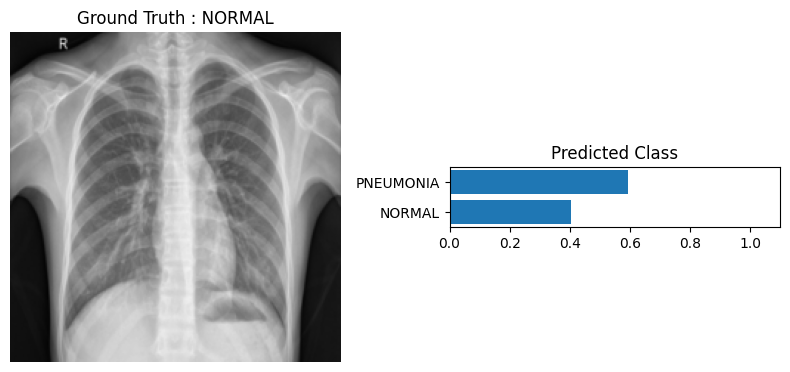

In [ ]:
# load an example and make prediction for it

image, label = testset[]

logit = model(image.to(device).unsqueeze(0)) #(3,224,224) -> (1,3,224,224) here we get the logits
ps = F.softmax(logit, dim = 1)

view_classify(image, ps, label)

In [ ]:
# saving the model to google drive for further optimization later

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/MyDrive/PneumoniaClassificationProject"
! cp PneumoniaModel.pt ./drive/MyDrive/PneumoniaClassificationProject